### Data load
data load and data size change(for fast caculation)

In [65]:
#feature selection을 위한 여러가지 방법
#    - wrapper : 예측 모델로 subset을 계속 테스트하여 구하는 방법
#        ex) RFE(SVM or other algorith)을 사용함, SFS(Greedy Algorithm), univariate(SKB), genetic
#    - filter : 관련성을 사용하여 상관관례를 알아내는 방법
#        ex) information gain, chi-quare test, fisher score, correlation coefficient. variance threshold
#    - embedded : 유용성을 측정하여 내장 metirc을 사용함.
#        ex) selecFromModel(decision treee 기반 algorithm)

In [20]:
# 정답이 될 결과 데이터와 예측에 사용될 입력 데이터로 구분
import pandas as pd
import numpy as np

data = pd.read_csv('Preprocessing_data.csv')# csv에서 로드시, int64, float64 호출되므로 int32, float32로 다시 변경
'''
for column in data.columns:
    if data[column].dtype == np.int64:
        maxVal = data[column].max()
        if maxVal < 120:
            data[column] = data[column].astype(np.int8)
        elif maxVal < 32767:
            data[column] = data[column].astype(np.int16)
        else:
            data[column] = data[column].astype(np.int32)
    if data[column].dtype == np.float64:
        maxVal = data[column].max()
        minVal = data[data[column]>0][column]
        if maxVal < 120 and minVal>0.01 :
            data[column] = data[column].astype(np.float16)
        else:
            data[column] = data[column].astype(np.float32)
'''

'\nfor column in data.columns:\n    if data[column].dtype == np.int64:\n        maxVal = data[column].max()\n        if maxVal < 120:\n            data[column] = data[column].astype(np.int8)\n        elif maxVal < 32767:\n            data[column] = data[column].astype(np.int16)\n        else:\n            data[column] = data[column].astype(np.int32)\n    if data[column].dtype == np.float64:\n        maxVal = data[column].max()\n        minVal = data[data[column]>0][column]\n        if maxVal < 120 and minVal>0.01 :\n            data[column] = data[column].astype(np.float16)\n        else:\n            data[column] = data[column].astype(np.float32)\n'

In [21]:
data = data[(data[' Label']!='Heartbleed') ]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1648847 entries, 0 to 1648857
Data columns (total 79 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0    Destination Port             1648847 non-null  int64  
 1    Flow Duration                1648847 non-null  int64  
 2    Total Fwd Packets            1648847 non-null  int64  
 3    Total Backward Packets       1648847 non-null  int64  
 4   Total Length of Fwd Packets   1648847 non-null  int64  
 5    Total Length of Bwd Packets  1648847 non-null  int64  
 6    Fwd Packet Length Max        1648847 non-null  int64  
 7    Fwd Packet Length Min        1648847 non-null  int64  
 8    Fwd Packet Length Mean       1648847 non-null  float64
 9    Fwd Packet Length Std        1648847 non-null  float64
 10  Bwd Packet Length Max         1648847 non-null  int64  
 11   Bwd Packet Length Min        1648847 non-null  int64  
 12   Bwd Packet Length Mean     

In [22]:
data[' Label'].value_counts()

BENIGN              1096474
DoS Hulk             230124
PortScan             158804
DDoS                 128025
DoS GoldenEye         10293
FTP-Patator            7935
SSH-Patator            5897
DoS slowloris          5796
DoS Slowhttptest       5499
Name:  Label, dtype: int64

In [23]:
X = data.drop(columns=[' Label'], axis = 0)
y = data[' Label']

In [23]:
# DoS Hulk(230124개) : 공격자가 HTTP request URL 정보를 패래미터를 변경시키면서 요청을 발생시켜 과부하(Threshold)를 내는것.

# Port Scan(158804개): 공격자가 열린 포트를 찾고 데이터 수신 또는 전송 여부를 할려는 것.

# DDoS(128025개) : 여러대의 공격자를 분산적으로 두어 서비스 거부를 하는 것.

# DoS
# GoldenEye(10293개) : 공격 툴 프로그램으로 DoS공격
# slowhttptest(5499개) : (Read) DoS 를 시뮬레이션 하기 위한 툴
# Slowloris(5796개) : (Header) 공격자가 서비스 서버와 정상 세션을 맺고 비정상적 헤더값을 서버로 요청해서 open connection을 유지

# FTP-Patator(7935개) : Patator 암호 추측 공격등 Brute-Force를 위한 검증 툴 (FTP)
# SSH-Patator(5897개) : Patator 암호 추측 공격등 Brute-Force를 위한 검증 툴 (SSH)

# Bot : 인터넷에 연결된 디바이스로 이루어지는 공격

# Web Attack - Brute Force, XSS, SQL Injection

# 그래서 차라리 label을 카테고리화 하는 것을 생각해볼 것


### selecKbest

In [24]:
# 1) selectkBest = ANOVA F value 로 score를 결정함 = univariate -> filter Method
# 즉, 집단에서의 독립변인을 검증함.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#score_func default value = f_clssif
# k = Number of top features to select, all을 사용하면 bypasses selection으로 줌. default= 10
bestfeatures = SelectKBest(score_func=f_classif, k = 10) 
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
n = len(featureScores['Specs'])//2  ##전체 입력데이터 attribute의 반만 보여줌.
# print(featureScores.nlargest(n,'Score'))
# 전체 feature의 반을 사용하여, feature를 뽑아내고, label을 붙여서 최종 feature를 완성.
feature = pd.DataFrame()
for i in featureScores.nlargest(n,'Score')['Specs']:
        feature[i] = data[i]
n

C:\Users\wnghk\anaconda3\envs\practice_sk\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning:

Features [31 32 33 49 56 57 58 59 60 61] are constant.

C:\Users\wnghk\anaconda3\envs\practice_sk\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning:

invalid value encountered in true_divide



39

In [25]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(orientation='h',y=featureScores.nlargest(n,'Score')['Specs'],
                     x=featureScores.nlargest(n,'Score')['Score'],
                     name='feature-score', marker_color='rgba(30, 144, 255, .8)'))
fig.update_layout(title='<b>selectKBest Score</b>',yaxis={'categoryorder':'total ascending'})

### Correlation

In [26]:
from matplotlib import pyplot as plt
import seaborn as sns

<AxesSubplot:>

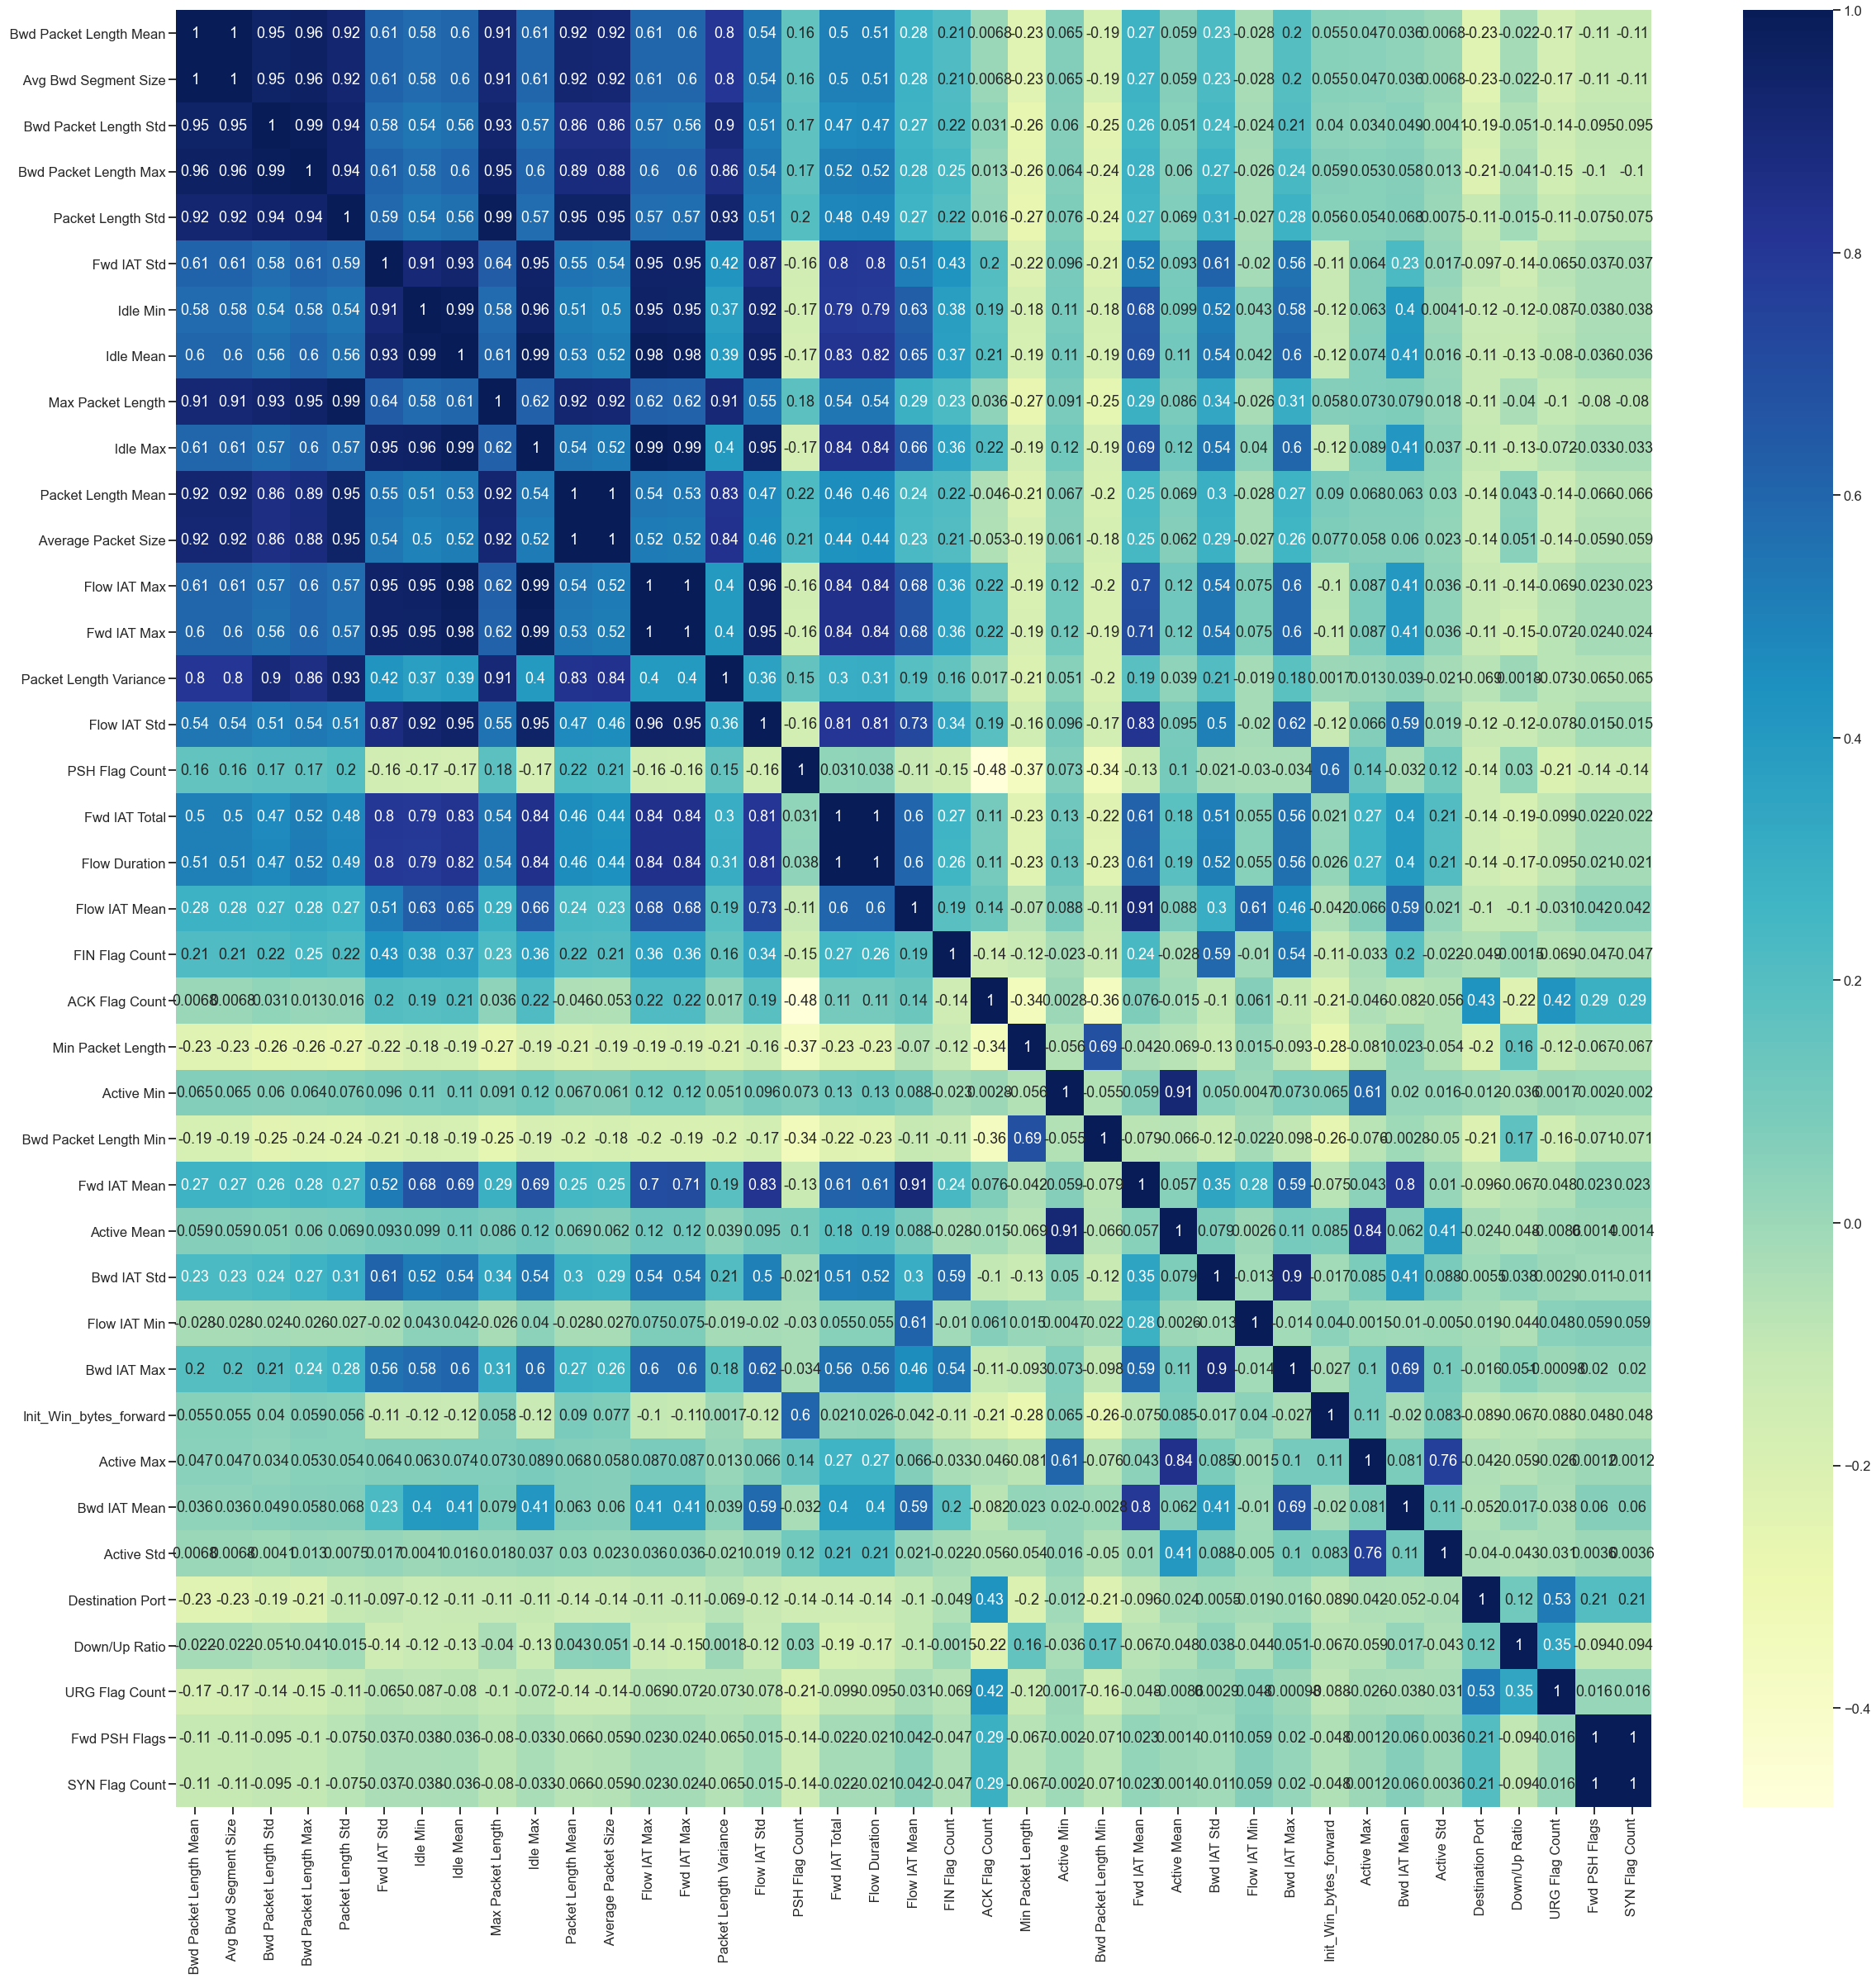

In [27]:
# drop 전
sns.set(style="ticks", context="talk")
fig = plt.figure(figsize=(40,40))
sns.heatmap(feature.corr(), annot=True, cmap="YlGnBu")

In [28]:
# corrleation 결과로 해당 부분에 필요없는 bulk부분 삭제
# Bwd PSH Flags, Bwd URG Flags, Fwd Avg Bytes/Bulk, Fwd Avg Packets/Bulk,
# Fwd Avg Bulk Rate, Bwd Avg Bytes/Bulk, Bwd Avg Packets/Bulk, Bwd Avg Bulk Rate
data_x = feature.copy()
drop_list = [' Bwd Packet Length Mean', ' Avg Bwd Segment Size', 'Bwd Packet Length Max',
             ' Packet Length Std', ' Average Packet Size', ' Packet Length Mean',
            ' Max Packet Length', ' Packet Length Variance', ' Idle Max', ' Flow IAT Max',
            ' Fwd IAT Max', ' Flow IAT Std', 'Idle Mean', 'Fwd IAT Total', ' Idle Min',
             'Fwd PSH Flags']

for col in drop_list:
    data_x.drop([col], axis =1, inplace=True)

In [29]:
#! pip install seaborn

<AxesSubplot:>

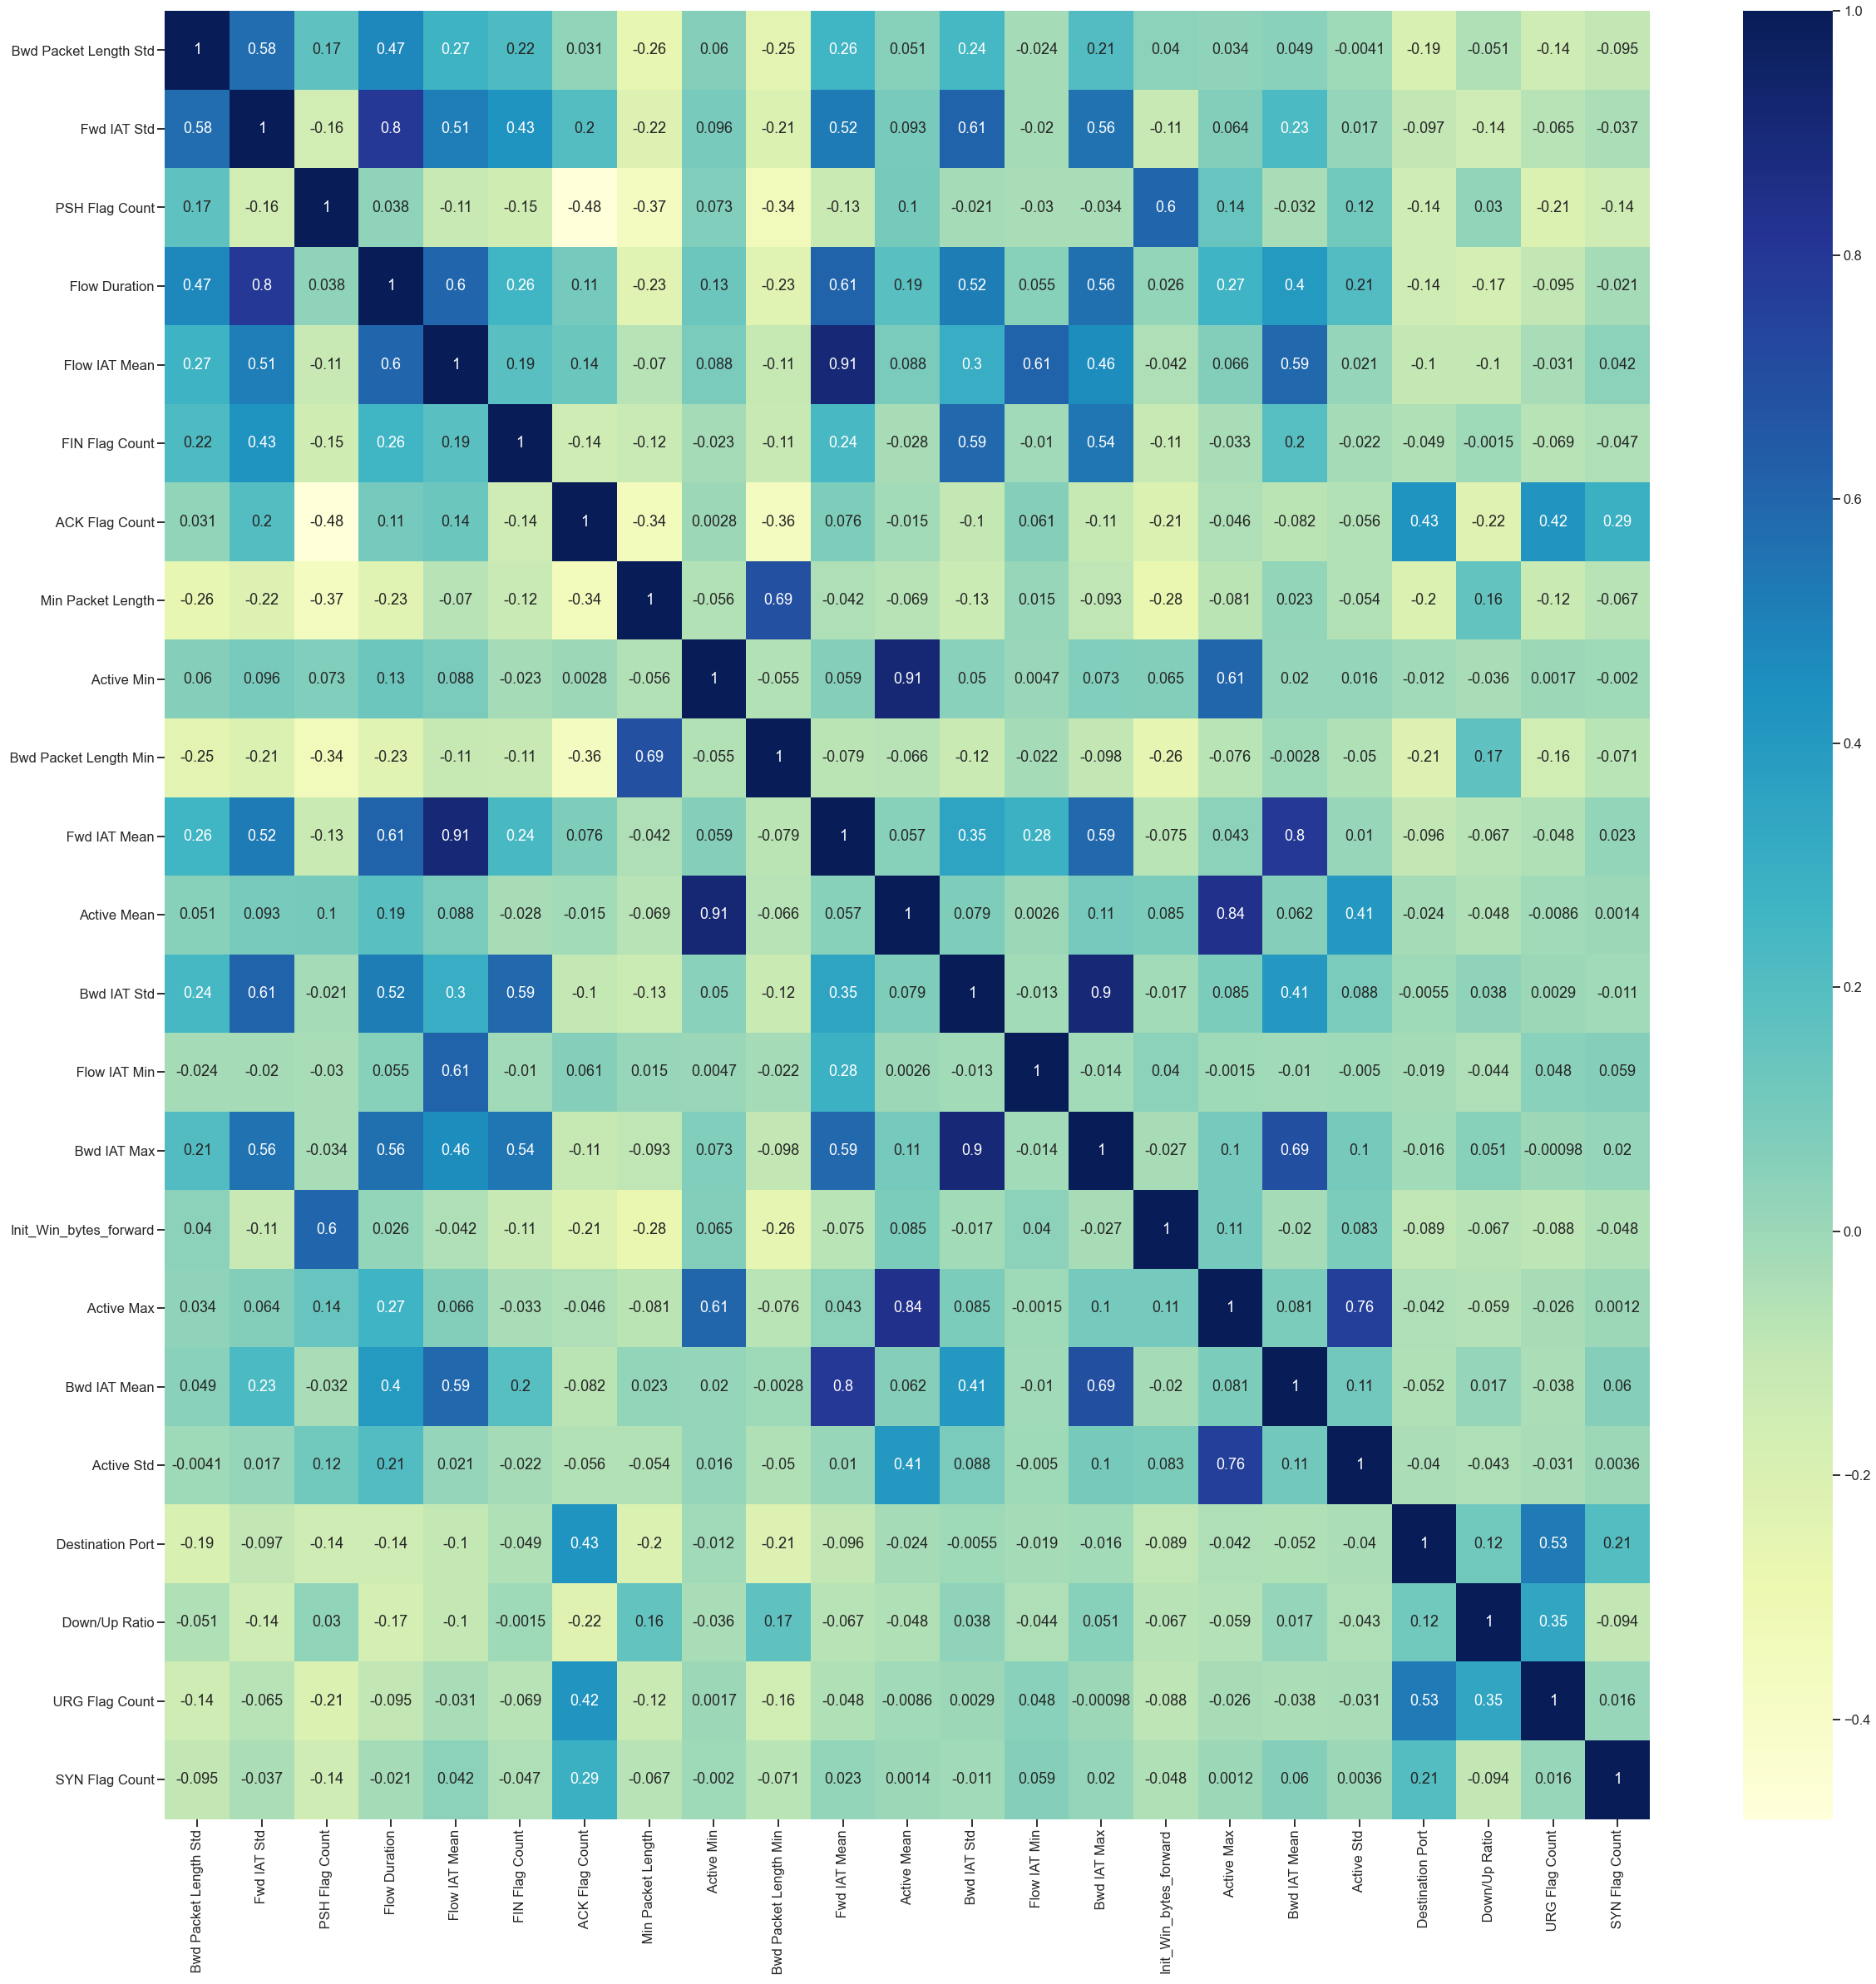

In [30]:
sns.set(style="ticks", context="talk")
fig = plt.figure(figsize=(40,40))
sns.heatmap(data_x.corr(), cmap="YlGnBu",annot=True)

In [31]:
data_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1648847 entries, 0 to 1648857
Data columns (total 23 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0    Bwd Packet Length Std  1648847 non-null  float64
 1    Fwd IAT Std            1648847 non-null  float64
 2    PSH Flag Count         1648847 non-null  int64  
 3    Flow Duration          1648847 non-null  int64  
 4    Flow IAT Mean          1648847 non-null  float64
 5   FIN Flag Count          1648847 non-null  int64  
 6    ACK Flag Count         1648847 non-null  int64  
 7    Min Packet Length      1648847 non-null  int64  
 8    Active Min             1648847 non-null  int64  
 9    Bwd Packet Length Min  1648847 non-null  int64  
 10   Fwd IAT Mean           1648847 non-null  float64
 11  Active Mean             1648847 non-null  float64
 12   Bwd IAT Std            1648847 non-null  float64
 13   Flow IAT Min           1648847 non-null  int64  
 14   B

In [32]:
y.value_counts()

BENIGN              1096474
DoS Hulk             230124
PortScan             158804
DDoS                 128025
DoS GoldenEye         10293
FTP-Patator            7935
SSH-Patator            5897
DoS slowloris          5796
DoS Slowhttptest       5499
Name:  Label, dtype: int64

In [33]:
#!pip install imblearn

### Data Save

In [34]:
data = pd.concat([data_x,y],axis=1)
data.to_csv('after_preprocessing.csv',index=False)

In [ ]:
x_train.to_csv("x_train.csv", index=False)
x_test.to_csv("x_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

### Sampling
over_sampling : SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smt = SMOTE({'DoS Hulk':230124, 'PortScan':230124, 'DDoS':230124, 'DoS GoldenEye': 230124,
             'FTP-Patator':230124, 'SSH-Patator':230124, 'DoS slowloris':230124, 'DoS Slowhttptest':230124})
X_smt, y_smt = smt.fit_resample(data_x, y)

# 경계선상의 데이터들의 조정.

In [ ]:
# check after
print(y_smt.value_counts())

### Label encoding
OneHotEncoding

In [15]:
# test, train data distributed
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_x, y, test_size= 0.3, random_state = 10)

In [16]:
x_train[' Destination Port'].value_counts()

80       349367
53       333921
443      166789
22         8061
21         7691
          ...  
36079         1
9466          1
11515         1
15007         1
31961         1
Name:  Destination Port, Length: 44037, dtype: int64

### Scaling
standardscale

In [17]:
# 정규화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# 조심해야할 부분, fit를 사용하는 순간 standard scale이 조정되기 때문에 이를 train에 맞추어서 동작
# fit_transform for train
cols = x_train.select_dtypes(include=['float64','int64']).columns
sc_train_x = scaler.fit_transform(x_train)
x_train = pd.DataFrame(sc_train_x, columns = cols)

#transorform for test
sc_test_x = scaler.transform(x_test)
x_test = pd.DataFrame(sc_test_x, columns = cols)

In [37]:
from sklearn.preprocessing import OneHotEncoder 

# creating one hot encoder object
'''
onehotencoder = OneHotEncoder() 

trainDep = y_train.values.reshape(-1,1)
trainDep = onehotencoder.fit_transform(trainDep).toarray()
testDep = y_test.values.reshape(-1,1)
testDep = onehotencoder.fit_transform(testDep).toarray()

y_train = trainDep[:,0]
y_test = testDep[:,0]

onehotencoder = OneHotEncoder() 
trainDep = y_train.values.reshape(-1,1)
trainDep = onehotencoder.fit_transform(trainDep).toarray()

testDep = y_test.values.reshape(-1,1)
testDep = onehotencoder.fit_transform(testDep).toarray()
trainDep.reshape(1,-1)

testDep.reshape(1,-1)
trainDep.shape'''

'\nonehotencoder = OneHotEncoder() \n\ntrainDep = y_train.values.reshape(-1,1)\ntrainDep = onehotencoder.fit_transform(trainDep).toarray()\ntestDep = y_test.values.reshape(-1,1)\ntestDep = onehotencoder.fit_transform(testDep).toarray()\n\ny_train = trainDep[:,0]\ny_test = testDep[:,0]\n\nonehotencoder = OneHotEncoder() \ntrainDep = y_train.values.reshape(-1,1)\ntrainDep = onehotencoder.fit_transform(trainDep).toarray()\n\ntestDep = y_test.values.reshape(-1,1)\ntestDep = onehotencoder.fit_transform(testDep).toarray()\ntrainDep.reshape(1,-1)\n\ntestDep.reshape(1,-1)\ntrainDep.shape'

In [ ]:
# !pip install xgboost

### Feature Selection - Embedded
Random Forest <br>
Gradient Boosting <br>
XGBoost

In [37]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=0)
gbc_model = gbc.fit(x_train,y_train) 

train_score = gbc.score(x_train,y_train)
print('{:.3f}'.format(train_score))
test_score = gbc.score(x_test,y_test)
print('{:.3f}'.format(test_score))

# pruning
gbc_prnd = GradientBoostingClassifier(random_state=0,max_depth=1)
gbc_prnd_model = gbc_prnd.fit(x_train,y_train)

train_score_prnd = gbc_prnd.score(x_train,y_train)
print('{:.3f}'.format(train_score_prnd))
test_score_prnd = gbc_prnd.score(x_test,y_test)
print('{:.3f}'.format(test_score_prnd))

0.997
0.997
0.986
0.985


In [18]:
import joblib

gbc_model = joblib.load(open('gbc_model.pkl', 'rb'))
score = gbc_model.score(x_test,y_test)

score = np.round(gbc_model.feature_importances_,3)
importances = pd.DataFrame({'importance':score,'feature':x_test.columns})
importances = importances.sort_values('importance',ascending=False)

In [19]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(orientation='h',y=importances['feature'],
                     x=importances['importance'],
                     name='feature-score', marker_color='rgba(30, 144, 255, .8)'))
fig
fig.update_layout(title='<b>Gradient Boosting Score</b>',yaxis={'categoryorder':'total ascending'})

### 2) Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':x_train.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [80]:
import joblib

rfc = joblib.load(open('rfc.pkl', 'rb'))
score = rfc.score(x_test,y_test)

score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'importance':score,'feature':x_test.columns})
importances = importances.sort_values('importance',ascending=False)

In [81]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(orientation='h',y=importances['feature'],
                     x=importances['importance'],
                     name='feature-score', marker_color='rgba(30, 144, 255, .8)'))
fig.update_layout(title='<b>Random Forest Score</b>',yaxis={'categoryorder':'total ascending'})

### 3) XGBoost

In [41]:
#!pip install xgboost

In [ ]:
# 1-1) xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# x_train, x_test, y_train, y_test
xgb = XGBClassifier()
# xgb의 hyperparameter (튜닝이 필요한 부분!)
# learning_rate : 학습률 default 0.3 일반적으로 0.01 ~ 0.2
# n_estimater : 학습기의 개수(반복 수행 횟수) 즉, tree의 수
# min_child_weight : 과적합을 조절하기 위한 leaf 조절
# max_depth : 트리의 최대 깊이 일반적으로 3 ~ 10
# subsample : 샘플링 비율
# early_stoppings: 더이상 cost 평가 지표가 감소하지 않은 최대 반복 횟수(조기 중단)
# eval_metric: 반복 수행시 사용하는 cost 평가 지표
# eval_set :평가를 수행하는 별도의 검증 데이터

# 값은 매우 적은 경우의 수로 테스트
xgb_param_grid = {
    'n_estimators' : [100],
    'learning_rate' : [0.2],
    'max_depth' : [4]
    #'early_stoppings': 100
}
# GridSearchCV : 위에서 정해놓은 param_grid의 리스트에서 hyperparameter를 참조하여 실행함.
# n_jobs = 병렬 처리 수
xgb_grid = GridSearchCV(xgb, param_grid = xgb_param_grid, scoring="accuracy", n_jobs=-1, verbose = 1,cv = 3)
xgb_grid.fit(x_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [43]:
print(xgb_grid.best_score_)

0.9994099768586127


In [49]:
import joblib
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

hd = list(x_test.columns)
xgb_grid = joblib.load(open('xgb_grid.pkl', 'rb'))
df = pd.DataFrame(columns=['feature', 'score'])
for i,f in zip(hd,xgb_grid.best_estimator_.feature_importances_):
    df.append({'feature':i,'score':f},ignore_index=True)


array([0.11893626, 0.09062766, 0.36751682, 0.07631434, 0.00608084,
       0.02913612, 0.02975995, 0.06255791, 0.02636123, 0.03031252,
       0.0113745 , 0.00275244, 0.00636677, 0.00499491, 0.00990841,
       0.02503113, 0.01317624, 0.00506739, 0.01560408, 0.05164425,
       0.01069376, 0.00219884, 0.00358373], dtype=float32)

In [ ]:
import joblib

joblib.dump(gbc_model,'gbc_model.pkl')
joblib.dump(rfc,'rfc.pkl')
joblib.dump(xgb_grid,'xgb_grid.pkl')

In [42]:
import numpy as np

a= np.array([[1,2],[3,4]])
b=np.array([10,20])
a*b

array([[10, 40],
       [30, 80]])